In [1]:
import keras
from operator import truediv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.python.keras import layers
#from keras.utils.image_utils import img_to_array, load_img, array_to_img
#from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.python.keras.models import Model
import datetime


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


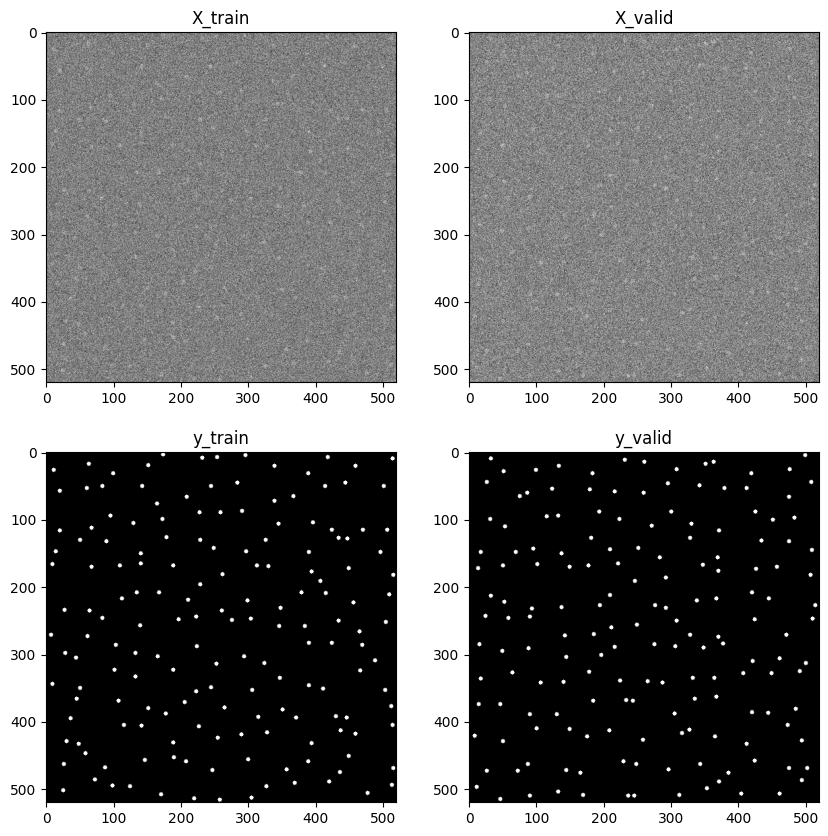

In [3]:
# 画像の読み込みパート

seed = 1
img_height = 520
img_width = 520
batch_size = 4
epochs = 100

params = {
    # 'rotation_range': 180,
    # 'horizontal_flip' : True,
    # 'vertical_flip' : True,
    'rescale': 1.0 / 255,
    'validation_split': 0.2,
}
#optimizer = Adam(lr=0.001)
steps_per_epochs = 4000/batch_size
validation_steps = 1000/batch_size

datagen = ImageDataGenerator(**params)

X_path = "D:/kobayashi/M2/520/CGI/1-5000"

X_train_directory = datagen.flow_from_directory(
    directory = X_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, seed=seed, subset='training',
)

y_path = "D:/kobayashi/M2/520/Object/r3"

y_train_directory = datagen.flow_from_directory(
    directory = y_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, subset='training',
)

train_zip = zip(X_train_directory, y_train_directory)

X_valid_directory = datagen.flow_from_directory(
    directory = X_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, seed=seed, subset='validation'
)

y_valid_directory = datagen.flow_from_directory(
    directory = y_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, subset='validation'
) 

valid_zip = zip(X_valid_directory, y_valid_directory)


# 4つのplotを表示
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(X_train_directory.next()[0], cmap='gray')
ax[0, 0].set_title('X_train')
ax[1, 0].imshow(y_train_directory.next()[0], cmap='gray')
ax[1, 0].set_title('y_train')
ax[0, 1].imshow(X_valid_directory.next()[0], cmap='gray')
ax[0, 1].set_title('X_valid')
ax[1, 1].imshow(y_valid_directory.next()[0], cmap='gray')
ax[1, 1].set_title('y_valid')
plt.show()


In [4]:
# モデル構築パート

input = layers.Input(shape=(img_height, img_width, 1))

x = layers.Conv2D(64, (7, 7), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (7, 7), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (7, 7), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(32, (7, 7), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (7, 7), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (7, 7), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (7, 7), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (7, 7), activation="sigmoid", padding="same")(x)


autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", metrics=["mae"], loss='binary_crossentropy',)

log_dir = "D:/kobayashi/Python/Python/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=3)

autoencoder.summary()

history_callback = autoencoder.fit(
    x=train_zip,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False, 
    validation_data=valid_zip,     
    steps_per_epoch=steps_per_epochs,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback, callback]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 520, 520, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 520, 520, 64)      3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 260, 260, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 260, 260, 64)      200768    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 130, 130, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 130, 64)      200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 65, 64)        0     

In [5]:
loss_history = history_callback.history
filename = 'ep' + str(epochs) + '_valloss' + str(loss_history['val_loss'][-1]) + '_block1'
save_path = "D:/kobayashi/M2/520/Models/5000_" + filename + '.h5'
autoencoder.save(save_path)

In [6]:
# モデルの読み込み
# autoencoder = tf.keras.models.load_model("D:/kobayashi/M2/520/Models/ep15_valloss0.0011286368826404214_block1.h5")

# 実験画像でのテスト
predict_test_data = datagen.flow_from_directory(
    directory = "D:/kobayashi/M2/520/Predict/X", target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=1, shuffle=None, seed=seed
)

predictions = autoencoder.predict(predict_test_data)

# 2つのplotを表示
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(predict_test_data.next()[0], cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(predictions[0], cmap='gray')
ax[1].set_title('Denoised') 
plt.show()

# 画像を保存
img = predictions[0]
img = np.squeeze(img)

# filename = "ep30_block6"
plt.imsave("D:/kobayashi/M2/520/Predict/Output/" + filename + '.png' , img, cmap='gray')

Found 1 images belonging to 1 classes.


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_transpose_2/conv2d_transpose' defined at (most recent call last):
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\cs13\AppData\Local\Temp\ipykernel_16312\305182474.py", line 10, in <module>
      predictions = autoencoder.predict(predict_test_data)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1741, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1577, in predict_function
      return step_function(self, iterator)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1567, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1560, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1533, in predict_step
      return self(x, training=False)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1044, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 420, in call
      inputs, training=training, mask=mask)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 555, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1044, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 1326, in call
      dilation_rate=self.dilation_rate)
    File "c:\Users\cs13\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\backend.py", line 5409, in conv2d_transpose
      data_format=tf_data_format)
Node: 'model/conv2d_transpose_2/conv2d_transpose'
OOM when allocating tensor with shape[1,64,520,520] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_transpose_2/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_418698]